Testing the quality of the redshift cuts on LSST Y1 and Y10 catalogs, plus Euclid photometry

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import jax.numpy as jnp
from jax.experimental.optimizers import adam
from pzflow import FlowEnsemble
from pzflow.bijectors import Chain, StandardScaler, RollingSplineCoupling
from pzflow.distributions import Uniform

Load the catalogs and split them into training and test sets

In [2]:
y1_catalog = pd.read_pickle("catalogs/y1_catalog_w_u_nondetects.pkl")
y10_catalog = pd.read_pickle("catalogs/y10_catalog_w_u_nondetects.pkl")

N_train = int(100e3)
N_test = int(20e3)

y1_sample = y1_catalog.sample(n=N_train + N_test, random_state=0)
y1_train, y1_test = y1_sample[:N_train], y1_sample[N_train:] 

y10_sample = y10_catalog.sample(n=N_train + N_test, random_state=0)
y10_train, y10_test = y10_sample[:N_train], y10_sample[N_train:] 

Now let's create the bijector and latent distribution for the normalizing flows.

In [3]:
# I am abusing StandardScaler to make redshifts run (-5, 5)
means = 3.5 / 2
stds = (3.5 / 2) / 5

# construct our bijector
# by chaining all these layers
def get_bijector(n_conditions):
    return Chain(
        StandardScaler(means, stds),
        RollingSplineCoupling(nlayers=1, n_conditions=n_conditions),
    )

latent = Uniform((-5, 5))

Now we create a `FlowEnsemble` for each catalog

In [6]:
N = 10 # number of flows in each ensemble

# dictionary of Y1 ensembles
y1_ensembles = {
    name: FlowEnsemble(["redshift"], get_bijector(len(conditional_columns)), conditional_columns, latent, N)
    for name, conditional_columns in [
        ["LSST Y1 w/ u nondetects", list("grizy")],
        ["LSST Y1 + Euclid w/ u nondetects", list("grizy")+["ey"]+list("jh")],
    ]
}

# dictionary of Y10 ensembles
y10_ensembles = {
    name: FlowEnsemble(["redshift"], get_bijector(len(conditional_columns)), conditional_columns, latent, N)
    for name, conditional_columns in [
        ["LSST Y10 w/ u nondetects", list("grizy")],
        ["LSST Y10 + Euclid w/ u nondetects", list("grizy")+["ey"]+list("jh")],
    ]
}

Now let's train the ensembles

In [7]:
def train_ensembles(ensembles: dict, train_set: pd.DataFrame, test_set: pd.DataFrame):
    
    # loop through the ensembles
    for name, ens in ensembles.items():
        
        # print the catalog name
        print(f"{name:<35}", end="")

        # train the ensemble on the given learning rate schedule
        step_sizes = [1e-3, 2e-4, 1e-4]
        N_epochs = [40, 40, 20]
        seeds = [123, 312, 231]
        losses = [
            ens.train(train_set,
                      sample_errs=False,
                      optimizer=adam(step_size = step_size),
                      epochs=epochs,
                      seed=seed)
            for (step_size, epochs, seed) in zip(step_sizes, N_epochs, seeds)
        ]

        # we want to repackage the losses from each stage of training
        # so that each losses is a dict of flow_name: all_losses
        losses = {fname : # for each flow trained in the ensemble...
                      [float(loss) # save the list of training losses
                       for lossDict in losses
                       for loss in lossDict[fname]]
                  for fname in losses[0]}

        # print the train and test loss
        train_loss = -np.mean(ens.log_prob(train_set))
        test_loss = -np.mean(ens.log_prob(test_set))
        print(f"train = {train_loss:.3f}    test = {test_loss:.3f}")

        # save the ensemble
        save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
        ens.save(f"saved-ensembles/pzflow_ensemble_{save_name}.pkl")
        # and the losses
        with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "wb") as file:
            pickle.dump({"losses": losses, 
                         "train loss": train_loss, 
                         "test loss": test_loss},
                        file)

In [8]:
%%time
train_ensembles(y1_ensembles, y1_train, y1_test)
train_ensembles(y10_ensembles, y10_train, y10_test)

LSST Y1 w/ u nondetects train = -1.090    test = -1.062
LSST Y1 + Euclid w/ u nondetectstrain = -1.365    test = -1.342
LSST Y10 w/ u nondetectstrain = -1.356    test = -1.354
LSST Y10 + Euclid w/ u nondetectstrain = -1.554    test = -1.547
CPU times: user 27min 14s, sys: 1min 44s, total: 28min 59s
Wall time: 13min 54s


Let's plot the training losses for both sets of ensembles to make sure everything looks okay.

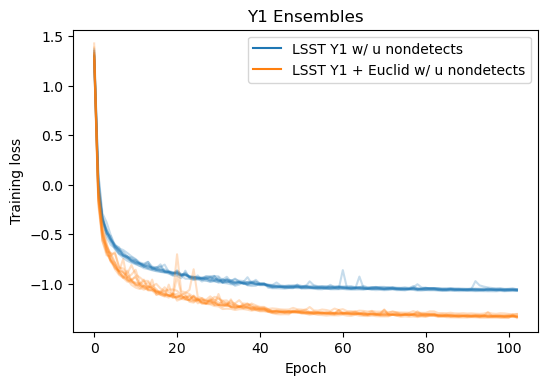

In [9]:
fig, ax = plt.subplots(dpi=100)

for i, name in enumerate(y1_ensembles):
    save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
    with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    for loss in losses.values():
        ax.plot(loss, c=f"C{i}", alpha=0.25)
    ax.plot([], c=f"C{i}", label=name)
    
ax.legend()
ax.set(title="Y1 Ensembles", xlabel="Epoch", ylabel="Training loss")
plt.show()

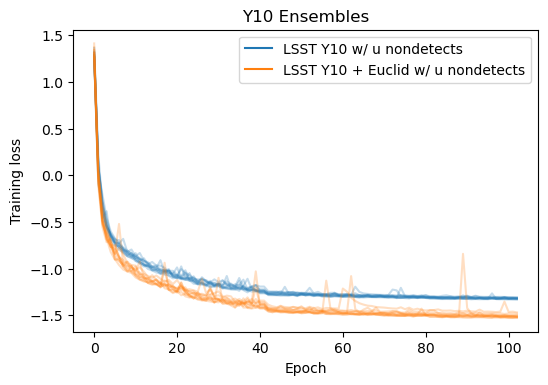

In [10]:
fig, ax = plt.subplots(dpi=100)

for i, name in enumerate(y10_ensembles):
    save_name = name.replace('+ ', '+').replace(' ', '_').replace('/', '')
    with open(f"saved-ensembles/losses/losses_for_{save_name}.pkl", "rb") as file:
        losses = pickle.load(file)["losses"]
    
    for loss in losses.values():
        ax.plot(loss, c=f"C{i}", alpha=0.25)
    ax.plot([], c=f"C{i}", label=name)
    
ax.legend()
ax.set(title="Y10 Ensembles", xlabel="Epoch", ylabel="Training loss")
plt.show()

Load the ensembles from the files

In [4]:
y1_ensemble_names = ["LSST Y1 w/ u nondetects", "LSST Y1 + Euclid w/ u nondetects"]
y10_ensemble_names = ["LSST Y10 w/ u nondetects", "LSST Y10 + Euclid w/ u nondetects"]

y1_ensembles = {name: FlowEnsemble(file=f"saved-ensembles/pzflow_ensemble_{name.replace('+ ', '+').replace(' ', '_').replace('/', '')}.pkl") for name in y1_ensemble_names}
y10_ensembles = {name: FlowEnsemble(file=f"saved-ensembles/pzflow_ensemble_{name.replace('+ ', '+').replace(' ', '_').replace('/', '')}.pkl") for name in y10_ensemble_names}

We will aproximate the pdfs by drawing samples. I think this is a lot faster than calculating full pdfs, but I haven't tested this assumption.

In [5]:
Nsamples = 1000
y1_samples = {name: ens.sample(Nsamples, conditions=y1_test, seed=0) for name, ens in y1_ensembles.items()}
y10_samples = {name: ens.sample(Nsamples, conditions=y10_test, seed=0) for name, ens in y10_ensembles.items()}

Define a function that applies the redshift cuts and calculates the metrics.

In [6]:
# to calculate the size of these samples, 
# we need to get the full catalog, see how big
# the gold sample (i<25.3) is, and scale that number
# up to 4e9, per the SRD.
# This scaling will then be applied to the sample sizes
# to scale them from Melissa's catalog -> full LSST catalog
full_catalog = pd.read_csv(
    "catalogs/Euclid_trim_27p10_3p5_IR_4NUV.dat",
    delim_whitespace=True, comment='#', nrows=None, header=None,
    usecols=[i for i in range(1,11)],
    names=[
        "redshift", # truth
        "u", "g", "r", "i", "z", "y", # LSST
        "ey", "j", "h", # Euclid
    ]
)
catalog_scale = 4e9 / full_catalog[full_catalog["i"] < 25.3].shape[0]

# now we define a function to print the important metrics
def sample_metrics(
    samples: pd.DataFrame,    
    truth_test: pd.DataFrame,
    truth_full: pd.DataFrame,
    zmin: float = 2.3, # minimum redshift
    zmax: float = np.inf, # maximum redshift
    pcut: float = 0.95, # probability cut
    sort_column: str = "i"
):
    
    # sort the truth set
    truth_test_sorted = truth_test.sort_values(by=[sort_column])
    # sort the samples
    samples_sorted = samples.sort_values(by=[sort_column])
    
    # reshape so that each row corresponds to one glaxay in truth
    zsamples = samples_sorted.values[:, 0].reshape(truth_test.shape[0], -1)
    # get the probability that each galaxy passes the redshift cut
    prob_zcut = ((zsamples > zmin) & (zsamples < zmax)).mean(axis=1)
    # get the indices of the passing galaxies
    pass_true = np.where((truth_test_sorted["redshift"] > zmin) & (truth_test_sorted["redshift"] < zmax))[0]
    pass_pred = np.where(prob_zcut > pcut)[0]
    
    # compute the metrics
    passed = pass_pred.size / truth_test.shape[0]
    complete = np.isin(pass_true, pass_pred, assume_unique=True).mean()
    purity = np.isin(pass_pred, pass_true, assume_unique=True).mean()
    size = passed * truth_full.shape[0] * catalog_scale
    print(f"size = {size/1e6:>3.0f}M", end="     ")
    print(f"passed = {passed:.3f}", end="     ")
    print(f"completeness = {complete:.3f}", end="     ")
    print(f"purity = {purity:.3f}")

Calculate the metrics for the redshift > 2.3 cut:

In [7]:
print("cut redshift > 2.3")
for name, sample in y1_samples.items():
    print(f"{name:<35}", end=" ")
    sample_metrics(sample, y1_test, y1_catalog)
for name, sample in y10_samples.items():
    print(f"{name:<35}", end=" ")
    sample_metrics(sample, y10_test, y10_catalog)

cut redshift > 2.3
LSST Y1 w/ u nondetects             size =  12M     passed = 0.003     completeness = 0.080     purity = 1.000
LSST Y1 + Euclid w/ u nondetects    size =  37M     passed = 0.010     completeness = 0.244     purity = 1.000
LSST Y10 w/ u nondetects            size = 173M     passed = 0.029     completeness = 0.395     purity = 0.997
LSST Y10 + Euclid w/ u nondetects   size = 228M     passed = 0.038     completeness = 0.522     purity = 0.997


Calculate the metrics for the 1.5 < redshift < 2.3 cut:

In [8]:
print("cut 1.5 < redshift < 2.3")
for name, sample in y1_samples.items():
    print(f"{name:<35}", end=" ")
    sample_metrics(sample, y1_test, y1_catalog, zmin=1.5, zmax=2.3)
for name, sample in y10_samples.items():
    print(f"{name:<35}", end=" ")
    sample_metrics(sample, y10_test, y10_catalog, zmin=1.5, zmax=2.3)

cut 1.5 < redshift < 2.3
LSST Y1 w/ u nondetects             size = 113M     passed = 0.031     completeness = 0.155     purity = 0.990
LSST Y1 + Euclid w/ u nondetects    size = 335M     passed = 0.093     completeness = 0.458     purity = 0.989
LSST Y10 w/ u nondetects            size = 432M     passed = 0.072     completeness = 0.283     purity = 0.987
LSST Y10 + Euclid w/ u nondetects   size = 817M     passed = 0.136     completeness = 0.538     purity = 0.992


Let's calculate full pdfs

In [9]:
%%time 
z_grid = jnp.linspace(0, 3.5, 100)
y1_pdfs = {name: ens.posterior(y1_test, column="redshift", grid=z_grid) for name, ens in y1_ensembles.items()}
y10_pdfs = {name: ens.posterior(y10_test, column="redshift", grid=z_grid) for name, ens in y10_ensembles.items()}

CPU times: user 2.48 s, sys: 1.42 s, total: 3.9 s
Wall time: 8.32 s


Make a plot of photo-z vs spec-z

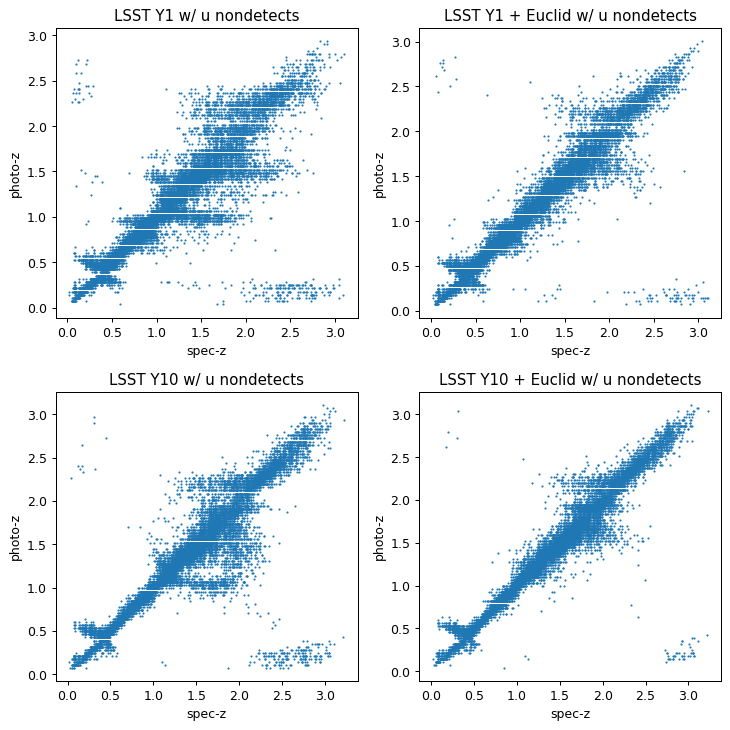

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(8,8), dpi=90, constrained_layout=True)

for i, (name, pdfs) in enumerate(y1_pdfs.items()):
    ax = axes.flatten()[i]
    
    zp = z_grid[pdfs.argmax(axis=1)]
    ax.scatter(y1_test["redshift"], zp, marker=".", s=2)
    ax.set(xlabel="spec-z", ylabel="photo-z", title=name)
    
for i, (name, pdfs) in enumerate(y10_pdfs.items()):
    ax = axes.flatten()[i+2]
    
    zp = z_grid[pdfs.argmax(axis=1)]
    ax.scatter(y10_test["redshift"], zp, marker=".", s=2)
    ax.set(xlabel="spec-z", ylabel="photo-z", title=name)

Let's calculate the metrics using a point estimate

In [11]:
# to calculate the size of these samples, 
# we need to get the full catalog, see how big
# the gold sample (i<25.3) is, and scale that number
# up to 4e9, per the SRD.
# This scaling will then be applied to the sample sizes
# to scale them from Melissa's catalog -> full LSST catalog
full_catalog = pd.read_csv(
    "catalogs/Euclid_trim_27p10_3p5_IR_4NUV.dat",
    delim_whitespace=True, comment='#', nrows=None, header=None,
    usecols=[i for i in range(1,11)],
    names=[
        "redshift", # truth
        "u", "g", "r", "i", "z", "y", # LSST
        "ey", "j", "h", # Euclid
    ]
)
catalog_scale = 4e9 / full_catalog[full_catalog["i"] < 25.3].shape[0]

# now we define a function to print the important metrics
def sample_metrics_point_estimate(
    pdfs: np.array,    
    truth_test: pd.DataFrame,
    truth_full: pd.DataFrame,
    zmin: float = 2.3, # minimum redshift
    zmax: float = np.inf, # maximum redshift
    pcut: float = 0.95, # probability cut
    sort_column: str = "i"
):

    # get the indices of the passing galaxies
    zp = z_grid[pdfs.argmax(axis=1)]
    pass_true = np.where((truth_test["redshift"] > zmin) & (truth_test["redshift"] < zmax))[0]
    pass_pred = np.where((zp > zmin) & (zp < zmax))[0]
    
    # compute the metrics
    passed = pass_pred.size / truth_test.shape[0]
    complete = np.isin(pass_true, pass_pred, assume_unique=True).mean()
    purity = np.isin(pass_pred, pass_true, assume_unique=True).mean()
    size = passed * truth_full.shape[0] * catalog_scale
    print(f"size = {size/1e6:>3.0f}M", end="     ")
    print(f"passed = {passed:.3f}", end="     ")
    print(f"completeness = {complete:.3f}", end="     ")
    print(f"purity = {purity:.3f}")

In [12]:
print("cut redshift > 2.3")
for name, pdfs in y1_pdfs.items():
    print(f"{name:<35}", end=" ")
    sample_metrics_point_estimate(pdfs, y1_test, y1_catalog, zmax=3.5)
for name, pdfs in y10_pdfs.items():
    print(f"{name:<35}", end=" ")
    sample_metrics_point_estimate(pdfs, y10_test, y10_catalog, zmax=3.5)

cut redshift > 2.3
LSST Y1 w/ u nondetects             size = 122M     passed = 0.034     completeness = 0.590     purity = 0.732
LSST Y1 + Euclid w/ u nondetects    size = 137M     passed = 0.038     completeness = 0.738     purity = 0.815
LSST Y10 w/ u nondetects            size = 376M     passed = 0.063     completeness = 0.778     purity = 0.903
LSST Y10 + Euclid w/ u nondetects   size = 420M     passed = 0.070     completeness = 0.880     purity = 0.915


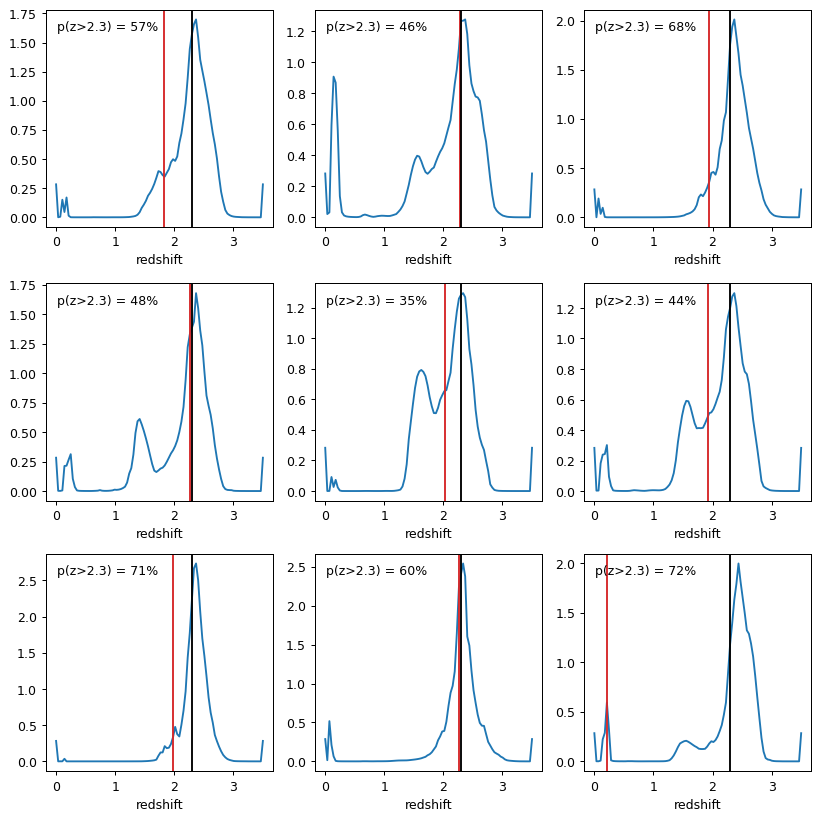

In [38]:
pdfs = y1_pdfs["LSST Y1 w/ u nondetects"]
idx = np.where((y1_test["redshift"] < 2.3) & (z_grid[pdfs.argmax(axis=1)] > 2.3))[0]

fig, axes = plt.subplots(3, 3, figsize=(9, 9), dpi=90, constrained_layout=True)

for i, ax in enumerate(axes.flatten()):
    
    ax.plot(z_grid, pdfs[idx[i]])
    ax.axvline(y1_test["redshift"].values[idx[i]], c="C3")
    ax.axvline(2.3, c="k")
    
    idx_min = np.argmin(np.abs(z_grid - 2.3))
    p = pdfs[idx[i]][idx_min:].sum() * (z_grid[1] - z_grid[0])
    ax.text(0.05, 0.95, f"p(z>2.3) = {100*p:.0f}%", ha="left", va="top", transform=ax.transAxes)
    ax.set(xlabel="redshift")